In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
plt.ion()   # interactive mode

In [ ]:
# image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y
# 0805personali01.jpg,27,83,27,98, ... 84,134
# 1084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312

In [3]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

n = 65  # 第65张图片
img_name = landmarks_frame.iloc[n, 0]  # 图片名
landmarks = landmarks_frame.iloc[n, 1:]  # 图片标记
landmarks = np.asarray(landmarks)  # landmarks.values 相同作用
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


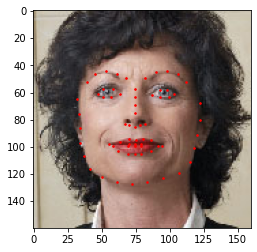

In [10]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)), landmarks)
plt.show()

In [ ]:
# torch.utils.data.Dataset 是代表数据集的抽象类。 

# 可覆盖方法:
#     __len__，以便len(dataset)返回数据集的大小。
#     __getitem__支持索引，以便可以使用dataset[i]获取第个样本
# 由于所有图像不会立即存储在内存中，而是根据需要读取，因此可以提高存储效率。

# 我们的数据集样本将是 dict {'image': image, 'landmarks': landmarks}。 
# 我们的数据集将使用可选参数transform，以便可以将任何所需的处理应用于样本。 我们将在下一部分中看到transform的有用性。

In [12]:
class FaceLandmarksDataset(Dataset):
    """面部标记图 dataset。所有图像不会立即存储在内存中，而是根据需要读取，因此可以提高存储效率"""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): 图片名字和标记点位置
            root_dir (string): 图片存放路径
            transform (callable, optional): 对每个样本都能进行的转化操作
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):  # 覆盖方法 以便len(dataset)返回数据集的大小。
        return len(self.landmarks_frame)

    def __getitem__(self, idx):  # 覆盖方法 支持索引，以便可以使用dataset[i]获取第个样本
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)  # 加载图片进入内存
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample  # 返回字典类型

In [14]:
# 生成 dataset
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                    root_dir='data/faces/')

# 打印前4张图片
fig = plt.figure()
for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

In [15]:
class Rescale(object):
    """ Transform 类 负责缩放图像，是数据增强。

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
        matched to output_size. If int, smaller of image edges is matched
        to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]  # 图片当前尺寸
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)  # 设置新的尺寸 像素点数量

        img = transform.resize(image, (new_h, new_w))  # 直接调用方法，重置图像尺寸

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]  # 标记点的位置也要对应放缩

        return {'image': img, 'landmarks': landmarks}  # 返回新的图

class RandomCrop(object):
    """Transform 类 负责图像切割

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):  # sample 是一个样本
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]  # 图片当前尺寸
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,  # 通过坐标随机切割
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}

class ToTensor(object):
    """将 numpy 图像转换为 torch 图像（我们需要交换轴）"""

    def __call__(self, sample):  # sample 是一个样本
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

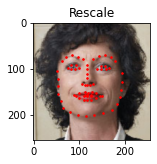

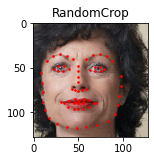

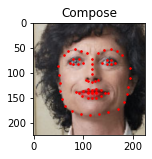

In [16]:
# 组合 Transform
scale = Rescale(256)  # 放缩图片大小
crop = RandomCrop(128)  # 随机切分图片大小
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

In [17]:
# 遍历数据集

transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()  # 因为要喂给模型，需要是Tonsor类型的数据
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


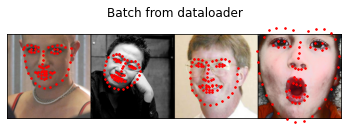

In [20]:
# 加载数据集

dataloader = DataLoader(transformed_dataset, 
                        batch_size=4,
                        shuffle=True, 
                        num_workers=0)

# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break